# **Options Pricing Using a Quantum Computer Demo**
### By: Austin Stiefelmaier
### Originally presented on 5-5-23

## Section 1: Options Background

Core Concepts:

- A financial option (also referred to as a derivative) is a contract between two parties that gives the buyer the right, but not the obligation, to buy or sell an underlying asset at a predetermined price and time.
- In general two broad types of financial options: 
  - Call: an option that gives the buyer the right to **buy** the underlying asset at a strike price before the expiration date.
  - Put: an option that gives the buyer the right to **sell** the underlying asset at the strike price before the expiration date.
- In order to understand the value of an option, one needs to calculate the expected payoff.
- Expected payoff typically varies based on the underlying asset, the strike price ($K$), the expiration date ($T$), and other factors such as volatility. 
- There are a variety of options types available such as European, American, Asian, etc. and some even have conditional payoffs depending on the path the price of the underlying asset has undergone until exercising.

Basics of Valuation:

- At their most basic form (e.g. European Call), payoff is defined as:
$max\{S_T - K, 0\}$
  - $S_T$ is spot price of underlying asset at time $T$ (i.e. maturity or the expiration date)
  - $K$ is the strike price
  - Take the maximum of the difference or 0 to account for choosing not to exercise the option
- Unlike the other values, $S_T$ is not predetermined and so (either through simulation or via closed form solutions of integrals) ultimately want to calculate the expected payoff for the actual value of an option (e.g. $\mathbb{E}[max\{S_T - K, 0\}]$)
  - In the real world, there are also premiums one typically pays and there is a need to discount the value (interest rate impact) so the actual cost of obtaining a contract is not this expectation exactly, but for our purposes it should be fine to simplify as is.
- Put options are of the reverse form (for European Put): $\mathbb{E}[max\{K - S_T, 0\}]$

Option of Interest: Lookback Option

- Considered an exotic option where, at the time of exercise, the most beneficial price of the underlying asset over the life of the contract is used
- Two Main Types:
  - Fixed Strike Lookback: as with most other options, $K$ is fixed at contract purchasel. Instead of spot price at maturity for the difference, the spot price leading to maximal difference in the holder's favor is used.
    - Call payoff: $max\{S_{max} - K, 0\}$
    - Put payoff: $max\{K - S_{min}, 0\}$
  - Floating Strike Lookback: uses spot price at maturity $S_T$, but $K$ is automatically set at maturity to be the spot price leading to maximal difference in the holder's favor.
    - Call payoff: $max\{S_{T} - S_{min}, 0\}$
    - Put payoff: $max\{S_{max} - S_{T}, 0\}$
    - Note that for floating strike $K$ has been replaced
- For this project, I have chosen to focus on the fixed strike version (specifically for a call, but puts are very similar)

## Section 2: Classical Options Pricing Using Monte Carlo Simulation 

Monte Carlo Intuition:

- Problem: Not all options valuation can be handled via a closed form solution such as the Black-Scholes equation. This lack of closed form solution can arise from the distribution of the underlying asset and/or complexity of payoff function (e.g. certain path-dependent payoffs). 
- Solution: Use numerical methods such as Monte Carlo simulation. Simulate many different paths that the underlying asset might take over the life of the contract. Calculate payoff for each path, and then average these payoffs to get an estimator for expected payoff. 
  - As the number of generated paths grows, then by the Central Limit Theorem, this estimator converges to the actual expected value (converges in $O(M^{-1/2})$ hwhere M is number of paths)

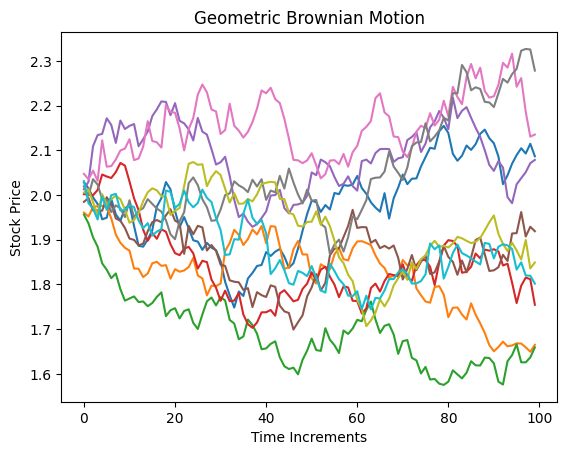

In [2]:
# European Call Option Pricing 
# (this is a sanity check with Qiskit code, actual lookback version implemented later on)
# Adapted from: https://www.codearmo.com/blog/pricing-options-monte-carlo-simulation-python
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


def get_paths(S, T, r, q, sigma, steps, N):
    """
    Inputs
    #S = Current stock Price
    #K = Strike Price
    #T = Time to maturity 1 year = 1, 1 months = 1/12
    #r = risk free interest rate
    #q = dividend yield
    # sigma = volatility 
    
    Output
    # [steps,N] Matrix of asset paths 
    """
    dt = T / steps
    ST = np.log(S) +  np.cumsum(((r - q - (sigma**2)/2)*dt + sigma * np.sqrt(dt) * np.random.normal(size=(steps, N))), axis=0)
    
    return np.exp(ST)

# NOTE: values below chosen to reflect small values for ease of comparison with quantum circuit
S = 2.0 #stock price S_{0}
K = 1.896 # strike
T = 40 / 365 # time to maturity in years
r = 0.0 # risk free risk in annual %
q = 0.0 # annual dividend rate
sigma = 0.4 # annual volatility in %
steps = 100 # time steps
N = 100000 # number of trials

paths = get_paths(S, T, r, q, sigma, steps, N) 

# Show example paths on a low N run
paths_graph = get_paths(S, T, r, q, sigma, steps, 10)
plt.plot(paths_graph)
plt.xlabel("Time Increments")
plt.ylabel("Stock Price")
plt.title("Geometric Brownian Motion")
plt.show()

In [3]:
# European Call Option Pricing Continueds
# Adapted from: https://www.codearmo.com/blog/pricing-options-monte-carlo-simulation-python
def black_scholes_call(S,K,T,r,q,sigma):
    """
    Inputs
    #S = Current stock Price
    #K = Strike Price
    #T = Time to maturity 1 year = 1, 1 months = 1/12
    #r = risk free interest rate
    #q = dividend yield
    # sigma = volatility 
    
    Output
    # call_price = value of the option 
    """
    d1 = (np.log(S/K) + (r - q + sigma**2/2)*T) / sigma*np.sqrt(T)
    d2 = d1 - sigma* np.sqrt(T)
    
    call = S * np.exp(-q*T)* norm.cdf(d1) - K * np.exp(-r*T)*norm.cdf(d2)
    return call



payoffs = np.maximum(paths[-1]-K, 0)
option_price = np.mean(payoffs)*np.exp(-r*T) #discounting back to present value

bs_price = black_scholes_call(S,K,T,r,q,sigma)

print(f"European Call Option Black Scholes Price is {bs_price}")
print(f"Monte Carlo Simulated price is {option_price}")

European Call Option Black Scholes Price is 0.1542091851827171
Monte Carlo Simulated price is 0.16418146618608354


In [4]:
# Lookback Monte Carlo
# Uses same paths function as before, but payoff calculation is different 
max_path = np.amax(paths, axis=0)
payoffs = np.maximum(max_path - K, 0)
option_price = np.mean(payoffs) * np.exp(-1 * r * T) #discounting back to present value
print(f"Lookback Option Simulated price is {option_price}")

Lookback Option Simulated price is 0.30724447899479634


## Section 3: Options Pricing Using a Quantum Computer

Why use a Quantum Computer?
- Quantum Amplitude Estimation (QAE) allows for the calculation of some parameter with M quantum samples with convergence rate of $O(M^{-1})$, which is a quadratic speedup over classical Monte Carlo.

General Procedure:
- Load a probability distribution
  - This can be challenging since the loading of arbitrary states into quantum systems requires exponentially many gates. Authors of Qiskit Finance package have created several helper functions that efficiently prepare common distributions (e.g. normal and lognormal).
  - In any case, distributions are represented across a set of qubits as encoded probabilities in $2^n$ bins, where $n$ is the number of qubits. So it is possible to approximate with more precision values in the distribution 
- Create payoff function
- Apply QAE to get the expected value of the payoff
  - Uses a modified QAE called Iterative Quantum Amplitude Estimation (IQAE) algorithm, that unlike the original algorithm does not rely on Quantum Phase Estimation, instead only using a series of Grover's algorithm iterations

### Section 3a: Loading a Probability Distribution

In [1]:
# Qiskit Import Statements
from qiskit.circuit.library import RYGate
from qiskit import Aer, QuantumCircuit, QuantumRegister, execute
from qiskit.visualization import plot_histogram
from qiskit_finance.circuit.library import LogNormalDistribution

import matplotlib.pyplot as plt
import numpy as np

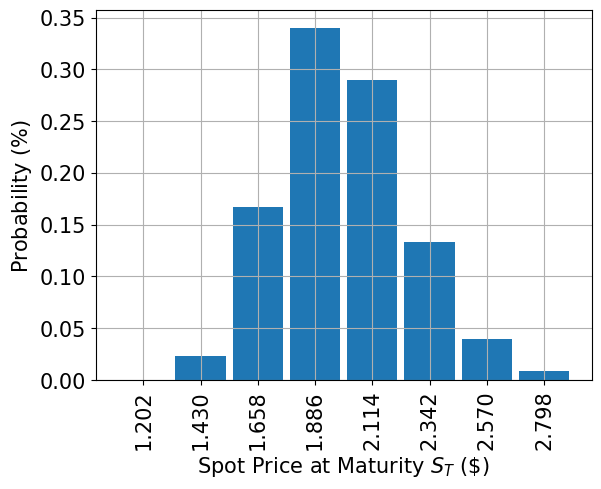

{'000': 0.00045373747366086315, '001': 0.02293123005752761, '010': 0.16681763338691646, '011': 0.33977530964942204, '100': 0.2893653136412476, '101': 0.13310021169749012, '110': 0.039223795624011924, '111': 0.008332768469723348}


In [5]:
# Defining a Lognormal Distribution using Qiskit Finance package
# NOTE: Nothing here "unique" except the ease of use for binning (and automatic creation of gates explained later)
# Code adapted from: https://qiskit.org/ecosystem/finance/tutorials/03_european_call_option_pricing.html

# number of qubits to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.0  # annual interest rate
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()

bin_probs = {'000': uncertainty_model.probabilities[0], '001': uncertainty_model.probabilities[1], '010': uncertainty_model.probabilities[2], 
             '011': uncertainty_model.probabilities[3], '100': uncertainty_model.probabilities[4], '101': uncertainty_model.probabilities[5],
             '110': uncertainty_model.probabilities[6], '111': uncertainty_model.probabilities[7]}
print(bin_probs)

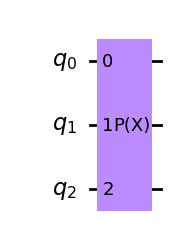

In [6]:
# Load in probability distribution using Qiskit finance package
# Uses pre-defined circuits that are much more efficient
num_qubits = 3
example_prob_load = QuantumCircuit(num_qubits)
example_prob_load.append(uncertainty_model, range(3))
example_prob_load.draw("mpl")

{'001': 0.0268, '000': 0.0001, '010': 0.1646, '100': 0.2829, '101': 0.1347, '110': 0.046, '111': 0.0091, '011': 0.3358}


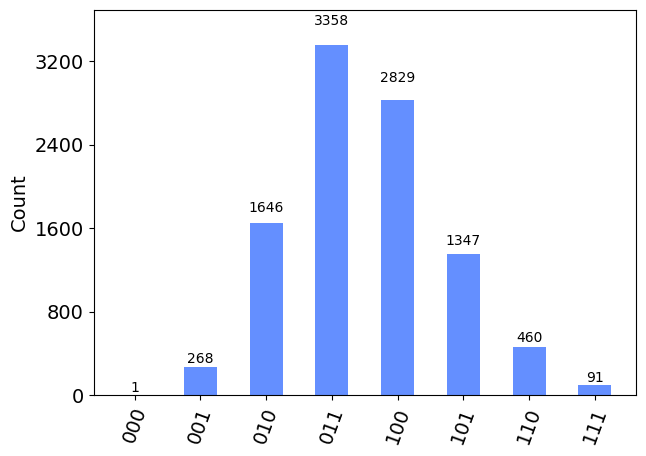

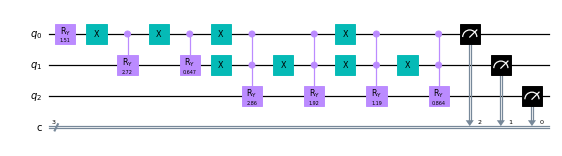

In [7]:
# Example circuit for manually loading in a distribution on 3 qubits (i.e. 8 bins)
# Code adapted from: https://medium.com/qiskit/systematic-preparation-of-arbitrary-probability-distribution-with-a-quantum-computer-165dfd8fbd7d

def circuit_bin8(theta0, theta1, theta2, theta3, theta4, theta5, theta6):
    """create |ψ3> state"""
    qc = QuantumCircuit(3, 3)
    # --- creating |ψ1> ----
    qc.ry(theta0, 0)
    # --- creating |ψ1> ----

    # === expanding |ψ1> into |ψ2> ===
    # apply RY(theta1) to the|0> state
    qc.x(0)
    qc.cry(theta1, 0, 1)
    qc.x(0)
    # apply RY(theta2) to the|1> state
    qc.cry(theta2, 0, 1)
    # === expanding |ψ1> into |ψ2> ===

    # ~~~ expanding |ψ2> into |ψ3> ~~~
    # apply RY(theta3) to the|00> state
    qc.x([0, 1])
    qc.append(RYGate(theta3).control(2), [0, 1, 2])
    qc.x(1)
    # apply RY(theta4) to the|10> state
    qc.append(RYGate(theta4).control(2), [0, 1, 2])
    qc.x(0)
    # apply RY(theta5) to the|10> state
    qc.x(1)
    qc.append(RYGate(theta5).control(2), [0, 1, 2])
    qc.x(1)
    # apply RY(theta6) to the|11> state
    qc.append(RYGate(theta6).control(2), [0, 1, 2])
    # ~~~ expanding |ψ2> into |ψ3> ~~~

    qc.measure([0, 1, 2], [2, 1, 0])
    return qc

# simulator setup
backend = Aer.get_backend("qasm_simulator")
shots = 10000

# aggregate the distribution into eight bins(as in original)
p0, p1 = np.array(np.array_split(uncertainty_model.probabilities, 2)).sum(axis=1)
theta0 = 2 * np.arccos(np.sqrt(p0))
p00, p01, p10, p11 = np.array(np.array_split(uncertainty_model.probabilities, 4)).sum(axis=1)
theta1 = 2 * np.arccos(np.sqrt(p00 / p0))
theta2 = 2 * np.arccos(np.sqrt(p10 / p1))
p000, p001, p010, p011, p100, p101, p110, p111 = uncertainty_model.probabilities
theta3 = 2 * np.arccos(np.sqrt(p000 / p00))
theta4 = 2 * np.arccos(np.sqrt(p010 / p01))
theta5 = 2 * np.arccos(np.sqrt(p100 / p10))
theta6 = 2 * np.arccos(np.sqrt(p110 / p11))

# construct circuit and measure
qc = circuit_bin8(theta0, theta1, theta2, theta3, theta4, theta5, theta6)
counts = execute(qc, backend, shots=shots, seed_simulator=1).result().get_counts()

# plot
ax1 = plt.figure(figsize=(7, 5), dpi=100, facecolor="w", linewidth=0, edgecolor="w").add_subplot(1, 1, 1)
ax2 = plt.figure(figsize=(7, 5), dpi=100, facecolor="w", linewidth=0, edgecolor="w").add_subplot(1, 1, 1)
plot_histogram(counts, ax=ax1)

qc.draw("mpl", ax=ax2)

for k in counts:
    counts[k] /= 10000
print(counts)

In [8]:
# Compare gate counts for manual loading vs finance package function
# Adapted from Medium article noted in previous cell

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller


def gate_decompose(qc):
    """decompose circuit to evaluate cost"""
    pass_ = Unroller(["u3", "cx"])
    return PassManager(pass_).run(qc).count_ops()

qc_bin8 = circuit_bin8(theta0, theta1, theta2, theta3, theta4, theta5, theta6)
print("Gate Decomposition for Manual Loading: " + str(gate_decompose(qc_bin8)))

print("Gate Decomposition for Qiskit Finance Loading: " + str(gate_decompose(example_prob_load)))

Gate Decomposition for Manual Loading: OrderedDict([('u3', 93), ('cx', 52), ('measure', 3)])
Gate Decomposition for Qiskit Finance Loading: OrderedDict([('u3', 7), ('cx', 6)])


### Section 3b: Payoff Function Setup

In [ ]:
# TODO: Payoff function setup

# IDEA: Use code for barrier option and/or Asian option from Stamatopoulos et al. "Option Pricing using Quantum Computers"
# Discretize time steps and treat as multiple small simulations, can get close to max overall (and really could be like looking at closing stock prices for instance)
# Similar to how there is an additional d quibits set aside for registering if a barrier has been passed in time steps, have a 
# set of qubits big enough to hold some max value and update max as one iterates through the t time steps, then use linear payoff over these with strike price

### Section 3c: Run Quantum Amplitude Estimation and Result

In [9]:
# Run QAE
# TODO: switch to use the payoff and probability load from sections 3a and 3b

# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[3],
    post_processing=european_call_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100})
)
result = ae.estimate(problem)
print("Estimated value:    \t%.4f" % (result.estimation_processed))

Traceback (most recent call last):
  Cell In[9], line 8
    problem = EstimationProblem(
NameError: name 'EstimationProblem' is not defined

Use %tb to get the full traceback.


# Section 4: Going Forward

Additional Project Plans:
- Implement lookback payoff for call version
- Compare performance to classical Monte Carlo simulation across various parameters (e.g. number of binning qubits for probability dist., how many time step splits)
  - Will be comparing with similar M (number of paths or calls to amplitude estimation) and then until reaching some high confidence level (for final accuracy)
  - Due to limitations of quantum model, the value in infinite M that it converges to will be different (but should be close) to that of the classical model
- Implement other versions of lookback (i.e. floating strike and fixed put) if time

Longterm Improvements:
- Investigate more complex distributions and how to load them into a quantum circuit. Possible approaches include qGANs (quantum generative adversarial networks) which attempt to replicate a distribution via parametrized rotation gates and SSQW (split-step quantum walks). 
- Experiment on real quantum hardware.
  - Likely difficult to run on meaningully large hardware given number of ancilla bits to encode time steps and max value logic, as well as overall number of gates will be highly error sensitive

## Section 5: Qiskit European Call Option

This section is intended as a sanity check.

In [10]:
# Adapted from: https://qiskit.org/ecosystem/finance/tutorials/03_european_call_option_pricing.html
from qiskit_finance.applications.estimation import EuropeanCallPricing
from qiskit.algorithms import IterativeAmplitudeEstimation
from qiskit_aer.primitives import Sampler

european_call_pricing = EuropeanCallPricing(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=1.896,
    rescaling_factor=0.25,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = european_call_pricing.to_estimation_problem()
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100})
)
result = ae.estimate(problem)

conf_int = np.array(result.confidence_interval_processed)
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Estimated value:    	0.1616
Confidence interval:	[0.1567, 0.1665]
